# **Time Series ML with LSTM with Keras (TF 2.0)**

This notebook is for me practicing time series ML with LSTM and based on **Multivariate Time Series Forecasting with LSTMs in Keras** by **Dr Jason Brownlee** . The great original work is here https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


The raw data file is a Beijing air quality dataset. the dataset was pre-processed a bit to be used in this work.

a **many-to-many** LSTM model is used for this multivariate and multi-step case.

![many-to-many](https://drive.google.com/uc?id=1S-j9w6nYi9eVo0NJaQ4gTZx6JAQJtZeu)

## modification from the original work in v1

1.   One-hot encoding is implemented for 'wind direction'.
2.   'hours' and 'day-of-year' features are added as seasonality factors
3.   Providing more multiple hours of input and output time steps.
4.   make output features selectable, automatically drop unwanted

## modification from v1

1.   implement multiple output timestep at data prep
2.   use many-to-many LSTM model with 2 stages
3.   simplify inverse scaling for output features
4.   change codes around for 'values' assignment to avoid re-run issue 
5.   more plots

## conditions


*   input timesteps = 12 hours
*   pred timestep = 4 hour
*   input features: all
*   output features: pm2.5, temp
*   train data duration: 4 years
*   test data duration: 1 year
*   neurons = 50
*   return_sequence = **false**  for 1st stage, **Ture** for output






























In [0]:
!pip install --upgrade -q tensorflow

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model



2.0.0


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')


## **Processing data**


In [0]:
# load dataset

gdrive="/content/gdrive/My Drive/Colab Notebooks/time series/data/"

dataset = pd.read_csv(gdrive + 'beijing_pm25_dp.csv', header=0, index_col=0)

In [94]:
dataset.head(10)

,pm2.5,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv,doy,hour
date,,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0,2,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0,2,1
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0,2,2
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0,2,3
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0,2,4
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,7.14,3,0,0,0,1,0,2,5
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,8.93,4,0,0,0,1,0,2,6
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,10.72,0,0,0,0,1,0,2,7
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,12.51,0,0,0,0,1,0,2,8


In [95]:
dataset.dtypes

pm2.5         float64
dew             int64
temp          float64
press         float64
wnd_spd       float64
snow            int64
rain            int64
wnd_dir_NE      int64
wnd_dir_NW      int64
wnd_dir_SE      int64
wnd_dir_cv      int64
doy             int64
hour            int64
dtype: object

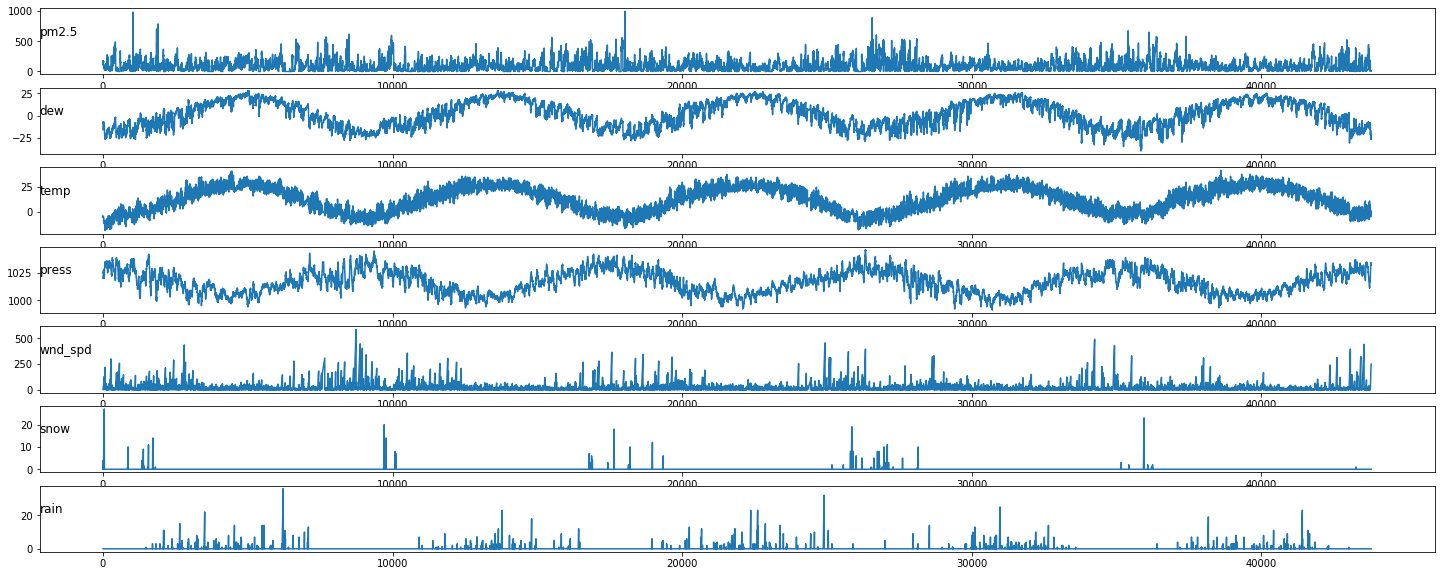

In [96]:
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(25,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(dataset.values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='left')
	i += 1
plt.show()

In [0]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [0]:
def drop_out_col(n_in, n_out, n_in_features, out_keep):
  columns=np.arange(n_in_features)
  columns=np.setdiff1d(columns, out_keep)

  drop = np.array([])
  for i in range(n_out):
    drop = np.append(drop, n_in_features*i+columns)
  
  drop+= n_in*n_in_features

  return np.int_(drop)


def name_to_col(dataset, name):
  return np.sort([dataset.columns.get_loc(c) for c in name if c in dataset])

In [249]:
# convert data to supervised learning format to feed LSTM 
# example: 
# input = 3 step, output = 1 time step, 3 features, pm2.5, rain, snow [0,5,6]
# each series has 13 features, input data has 3*13=39 column. output has 3, which are 39+[0,5,6]=[39,44,45]
# columns to drop from the output of series_to_supervised are [40,41,42,43,46,47,48,49,50,51]


# ensure all data is float
values = dataset.values.astype('float32')#drop(columns=['wnd_dir_NE', 'wnd_dir_NW',	'wnd_dir_SE',	'wnd_dir_cv'])
print(values.shape)

# specify the number of lag hours
n_in =12                        ################################################test

# output time step
n_out = 4                            ############################################test

# input features
n_in_features = values.shape[1]

# output features

out_features = ['pm2.5', 'temp']  

n_out_features = len(out_features)

keep_col = name_to_col(dataset, out_features)

out_features = dataset.columns[keep_col]

drop_col= drop_out_col(n_in, n_out, n_in_features, keep_col)

print(n_in_features, n_out_features)
print(out_features,keep_col)
print(drop_col)



# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#create scalar2 just for otuputs
scaler_out = MinMaxScaler(feature_range=(0, 1))
scaler_out.fit_transform(np.tile(values[:,keep_col], (1,n_out)))

print(scaled.shape,n_in,n_out)

reframed = series_to_supervised(scaled, n_in, n_out)
print(reframed.shape)
reframed.drop(reframed.columns[drop_col], axis=1, inplace=True)
print(reframed.shape)

(43800, 13)
13 2
Index(['pm2.5', 'temp'], dtype='object') [0 2]
[157 159 160 161 162 163 164 165 166 167 168 170 172 173 174 175 176 177
 178 179 180 181 183 185 186 187 188 189 190 191 192 193 194 196 198 199
 200 201 202 203 204 205 206 207]
(43800, 13) 12 4
(43785, 208)
(43785, 164)


In [250]:
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),var11(t-12),var12(t-12),var13(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),var6(t-11),var7(t-11),var8(t-11),var9(t-11),var10(t-11),var11(t-11),var12(t-11),var13(t-11),var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var9(t-10),var10(t-10),var11(t-10),var12(t-10),var13(t-10),var1(t-9),...,var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t),var3(t),var1(t+1),var3(t+1),var1(t+2),var3(t+2),var1(t+3),var3(t+3)
12,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.000000,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.043478,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,...,0.0,0.0,1.0,0.0,0.00274,0.391304,0.140845,0.485294,0.229508,0.636364,0.029018,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.434783,0.152918,0.470588,0.229508,0.636364,0.034367,0.0,0.0,0.0,0.0,1.0,0.0,0.00274,0.478261,0.148893,0.229508,0.164990,0.229508,0.158954,0.229508,0.154930,0.229508
13,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.043478,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,...,0.0,0.0,1.0,0.0,0.00274,0.434783,0.152918,0.470588,0.229508,0.636364,0.034367,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.478261,0.148893,0.470588,0.229508,0.636364,0.039716,0.0,0.0,0.0,0.0,1.0,0.0,0.00274,0.521739,0.164990,0.229508,0.158954,0.229508,0.154930,0.229508,0.159960,0.229508
14,0.159960,0.426471,0.229508,0.545454,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.086957,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,...,0.0,0.0,1.0,0.0,0.00274,0.478261,0.148893,0.470588,0.229508,0.636364,0.039716,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.521739,0.164990,0.470588,0.229508,0.618183,0.046586,0.0,0.0,0.0,0.0,1.0,0.0,0.00274,0.565217,0.158954,0.229508,0.154930,0.229508,0.159960,0.229508,0.164990,0.229508
15,0.182093,0.485294,0.229508,0.563637,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0,0.00274,0.130435,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,0.485294,0.213115,0.563637,0.011433,0.111111,0.0,0.0,0.0,1.0,0.0,0.00274,0.217391,0.105634,...,0.0,0.0,1.0,0.0,0.00274,0.521739,0.164990,0.470588,0.229508,0.618183,0.046586,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.565217,0.158954,0.455882,0.229508,0.618183,0.053456,0.0,0.0,0.0,0.0,1.0,0.0,0.00274,0.608696,0.154930,0.229508,0.159960,0.229508,0.164990,0.229508,0.171026,0.229508
16,0.138833,0.485294,0.229508,0.563637,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0,0.00274,0.173913,0.109658,0.485294,0.213115,0.563637,0.011433,0.111111,0.0,0.0,0.0,1.0,0.0,0.00274,0.217391,0.105634,0.485294,0.213115,0.581818,0.014492,0.148148,0.0,0.0,0.0,1.0,0.0,0.00274,0.260870,0.124748,...,0.0,0.0,1.0,0.0,0.00274,0.565217,0.158954,0.455882,0.229508,0.618183,0.053456,0.000000,0.0,0.0,0.0,1.0,0.0,0.00274,0.608696,0.154930,0.455882,0.229508,0.618183,0.060326,0.0,0.0,0.0,0.0,1.0,0.0,0.00274,0.652174,0.159960,0.229508,0.164990,0.229508,0.171026,0.229508,0.149899,0.229508


In [266]:
# split into train and test sets

n_train_hours = 365 * 24 *4  ############################################## test


train = reframed.values[:n_train_hours, :]
test = reframed.values[n_train_hours:, :]


# split into input and outputs

train_X, train_y = train[:, :n_in * n_in_features], train[:, -n_out_features*n_out:]
test_X, test_y = test[:, :n_in * n_in_features], test[:, -n_out_features*n_out:]
print(train_X.shape, len(train_X), train_y.shape)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_in_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_in_features))


train_y = train_y.reshape((train_y.shape[0], n_out, n_out_features))
test_y = test_y.reshape((test_y.shape[0], n_out, n_out_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 156) 35040 (35040, 8)
(35040, 12, 13) (35040, 4, 2) (8745, 12, 13) (8745, 4, 2)


## **LSTM model**


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 12, 13)]          0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 50)                12800     
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 4, 50)             0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 4, 50)             20200     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 4, 2)              102       
Total params: 33,102
Trainable params: 33,102
Non-trainable params: 0
_________________________________________________________________
None


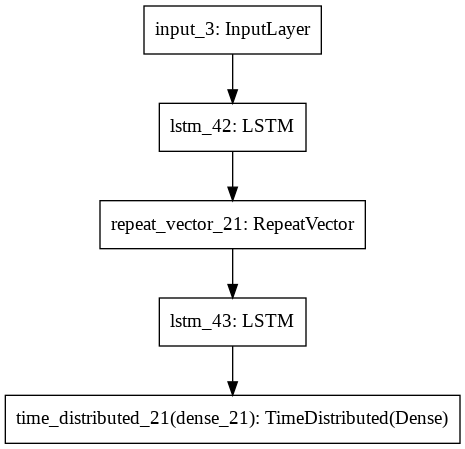

In [269]:
neurons=50 #########################################################test with grid search

inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))

X = LSTM(neurons, return_sequences=False, activation='relu')(inputs)
X = RepeatVector(n_out)(X)
X = LSTM(neurons, return_sequences=True, activation='relu')(X)
X = TimeDistributed(tf.keras.layers.Dense(units=n_out_features))(X)

model = Model(inputs, X)

model.compile(optimizer='adam', loss='mae', metrics=['mse'])

print(model.summary())

tf.keras.utils.plot_model(model)
#tf.keras.utils.plot_model(model, to_file='lstm-bjpm25-keras_graph.png')

#display(Image.open('lstm-bjpm25-keras_graph.png'))

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 50)                12800     
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 4, 50)             0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 4, 50)             20200     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 4, 2)              102       
Total params: 33,102
Trainable params: 33,102
Non-trainable params: 0
_________________________________________________________________
None


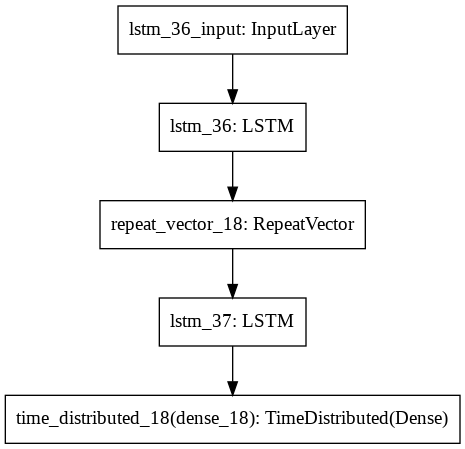

In [0]:
neurons=50 #########################################################test with grid search
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False, activation='relu'),
  tf.keras.layers.RepeatVector(n_out),
  tf.keras.layers.LSTM(neurons,return_sequences=True,activation='relu'),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=n_out_features))  # activation='linear'


])

model.compile(optimizer='adam', loss='mae', metrics=['mse'])

print(model.summary())

tf.keras.utils.plot_model(model)
#tf.keras.utils.plot_model(model, to_file='lstm-bjpm25-keras_graph.png')

#display(Image.open('lstm-bjpm25-keras_graph.png'))

## **Train model**


In [270]:

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 35040 samples, validate on 8745 samples
Epoch 1/50
35040/35040 - 9s - loss: 0.0665 - mse: 0.0090 - val_loss: 0.1307 - val_mse: 0.0268
Epoch 2/50
35040/35040 - 7s - loss: 0.0541 - mse: 0.0057 - val_loss: 0.1031 - val_mse: 0.0172
Epoch 3/50
35040/35040 - 7s - loss: 0.0573 - mse: 0.0069 - val_loss: 0.0808 - val_mse: 0.0110
Epoch 4/50
35040/35040 - 7s - loss: 0.0532 - mse: 0.0061 - val_loss: 0.0617 - val_mse: 0.0074
Epoch 5/50
35040/35040 - 7s - loss: 0.0468 - mse: 0.0050 - val_loss: 0.0526 - val_mse: 0.0058
Epoch 6/50
35040/35040 - 7s - loss: 0.0398 - mse: 0.0036 - val_loss: 0.0482 - val_mse: 0.0044
Epoch 7/50
35040/35040 - 7s - loss: 0.0338 - mse: 0.0025 - val_loss: 0.0444 - val_mse: 0.0037
Epoch 8/50
35040/35040 - 7s - loss: 0.0307 - mse: 0.0020 - val_loss: 0.0410 - val_mse: 0.0030
Epoch 9/50
35040/35040 - 7s - loss: 0.0283 - mse: 0.0017 - val_loss: 0.0364 - val_mse: 0.0024
Epoch 10/50
35040/35040 - 7s - loss: 0.0267 - mse: 0.0016 - val_loss: 0.0338 - val_mse: 0.0022
Epoch 11/5

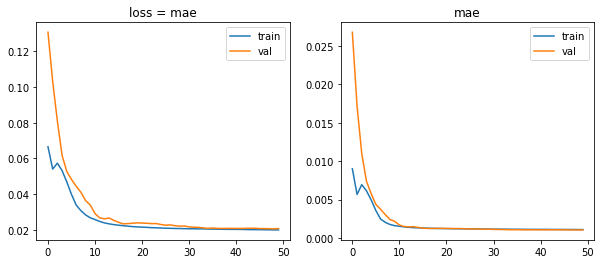

In [271]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('loss = mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='val')
plt.title('mae')
plt.legend()
plt.show() 

## **Prediction**

In [272]:
# make a prediction
yhat = model.predict(test_X)
yhat.shape

(8745, 4, 2)

In [0]:
yhat = yhat.reshape((len(yhat), n_out*n_out_features))
inv_yhat = np.round(scaler_out.inverse_transform(yhat).reshape((len(yhat), n_out,n_out_features)))

test_y=test_y.reshape((len(test_y), n_out*n_out_features))
inv_y = np.round(scaler_out.inverse_transform(test_y).reshape((len(test_y), n_out,n_out_features)))

In [274]:
# calculate RMSE
for i in range(n_out_features):
  print('forecast of %s' %(out_features[i]))
  for ts in range(n_out):
    rmse = np.sqrt(mean_squared_error(inv_y[:,ts,i], inv_yhat[:,ts,i]))
    mean = np.mean(inv_yhat[:,ts,i])
    print('timestep: %d, mean=%.2f, rmse=%.2f' % (ts,mean, rmse))

forecast of pm2.5
timestep: 0, mean=105.00, rmse=25.09
timestep: 1, mean=103.28, rmse=33.55
timestep: 2, mean=101.79, rmse=40.10
timestep: 3, mean=100.81, rmse=45.58
forecast of temp
timestep: 0, mean=13.51, rmse=1.24
timestep: 1, mean=13.60, rmse=1.54
timestep: 2, mean=13.71, rmse=1.76
timestep: 3, mean=13.79, rmse=1.97


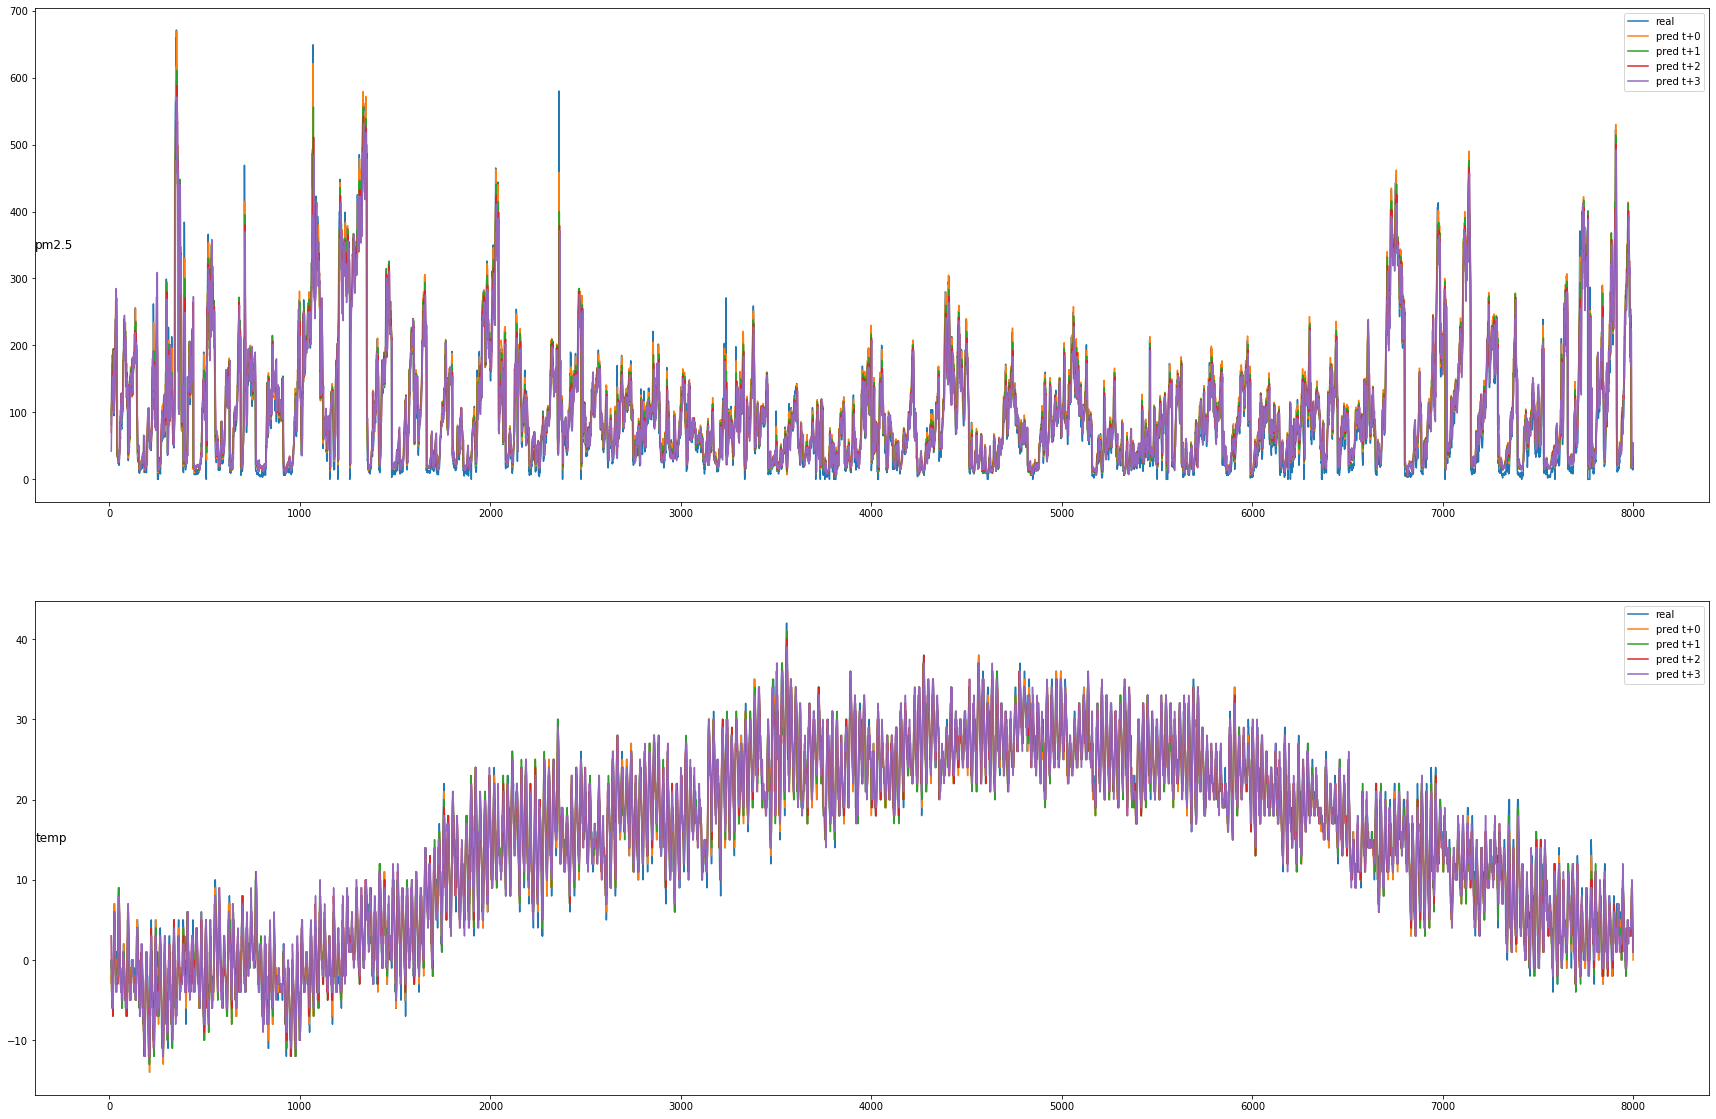

In [275]:
disp1=10
disp2=8000
x = np.arange(disp1,disp2)
plt.figure(figsize=(30,20))
for i in range(n_out_features): 
  plt.subplot(n_out_features ,1,i+1)
  plt.plot(x,inv_y[disp1:disp2,0,i], label='real')
  plt.title(out_features[i], y=0.5, loc='left')
  for ts in range(n_out) :
    plt.plot(x,inv_yhat[disp1-ts:disp2-ts,ts,i], label='pred t+%i'%ts)
    plt.legend()
    

plt.show() 

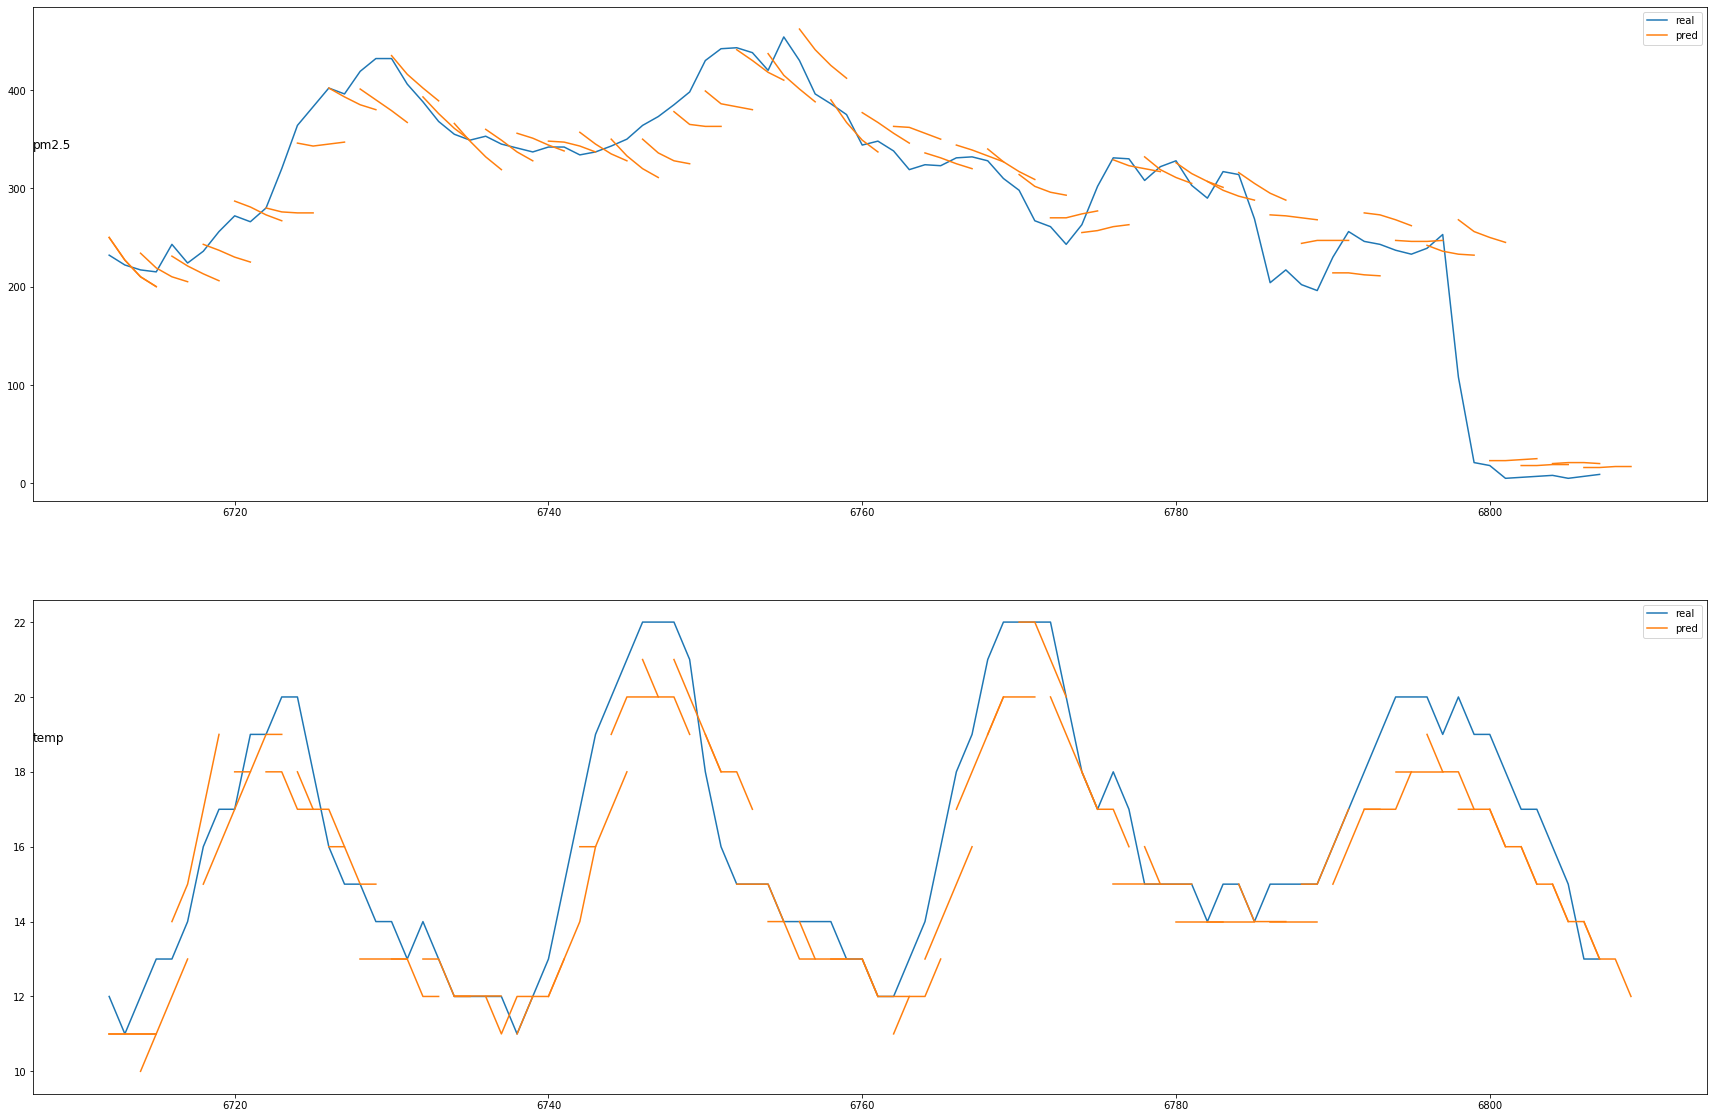

In [276]:
disp1=6712
disp2=6808
x = np.arange(disp1,disp2)
intv = 2
plt.figure(figsize=(30,20))
for i in range(n_out_features): 
  plt.subplot(n_out_features ,1,i+1)
  plt.plot(x,inv_y[disp1:disp2,0,i], label='real')
  plt.plot(x[0:n_out]+(disp1-disp1),inv_yhat[disp1,0:n_out,i], color='C1', label='pred')
  plt.legend()
  plt.title(out_features[i], y=0.7, loc='left')
  for disp in range(disp1,disp2,intv) :
    plt.plot(x[0:n_out]+(disp-disp1),inv_yhat[disp,0:n_out,i], color='C1', label='pred')
    
plt.show() 

## Output

In [0]:
#output.to_csv('time-series-bjpm25-lstm-v2.csv', index = False)


In [0]:
#model.save("time-series-bjpm25-lstm-v2.h5")

## **Remarks**

tests show that pm2.5 rmse is not sensitive to neuron number in the range of 40-100, lag hours 12-48

other 3 features also are not sensitive to neuron number 40-100, but improves as lag hours increase from 12-48

outputing pm2.5 with other features doesn't afffect the result.

'doy' plays a significant role in the training. it's especially obvious for the temperature prediction.


## **Future works**

*   internal state depends on number of days





# **Credit**

origianl work and referances are here

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://machinelearningmastery.com/start-here/#deep_learning_time_series

